1. 数据预处理和加载

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# 1. 数据预处理和加载
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_df, image_ids, transform=None, max_caption_length=30):
        self.image_dir = image_dir
        self.df = captions_df[captions_df['image'].isin(image_ids)].reset_index(drop=True)
        self.transform = transform
        self.max_caption_length = max_caption_length

        # 构建词汇表
        self.captions = self.df['caption'].tolist()
        self.vocab = self._build_vocab()
        self.word2idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        self.word2idx.update({word: idx+4 for idx, word in enumerate(self.vocab)})
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def _build_vocab(self, min_freq=2):
        counter = Counter()
        for caption in self.captions:
            tokens = word_tokenize(caption)
            counter.update(tokens)
        return [word for word, cnt in counter.items() if cnt >= min_freq]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image'])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = row['caption']
        tokens = ['<start>'] + word_tokenize(caption) + ['<end>']
        token_ids = [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]

        # 填充/截断
        if len(token_ids) < self.max_caption_length:
            token_ids += [self.word2idx['<pad>']] * (self.max_caption_length - len(token_ids))
        else:
            token_ids = token_ids[:self.max_caption_length]

        return image, torch.tensor(token_ids)



2. 创建DataLoader

In [ ]:
def load_and_filter_captions(token_file):
    """加载并过滤文本描述，只保留每个图像的#2描述"""
    captions = []
    with open(token_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                img_id, caption_num = parts[0].split('#')
                if caption_num == '2':
                    captions.append({'image': img_id, 'caption': parts[1].lower()})
    return pd.DataFrame(captions)

def load_split_image_ids(split_file):
    """加载划分文件的图像ID列表"""
    with open(split_file, 'r') as f:
        return [line.strip() for line in f]

def prepare_datasets():
    """准备训练集、验证集和测试集"""
    # 设置文件路径
    IMAGE_DIR = '/root/autodl-tmp/Flickr8k_Dataset/Flicker8k_Dataset'
    TOKEN_FILE = '/root/autodl-tmp/Flickr8k_text/Flickr8k.token.txt'
    TRAIN_SPLIT_FILE = '/root/autodl-tmp/Flickr8k_text/Flickr_8k.trainImages.txt'
    DEV_SPLIT_FILE = '/root/autodl-tmp/Flickr8k_text/Flickr_8k.devImages.txt'
    TEST_SPLIT_FILE = '/root/autodl-tmp/Flickr8k_text/Flickr_8k.testImages.txt'

    # 加载数据
    captions_df = load_and_filter_captions(TOKEN_FILE)
    train_ids = load_split_image_ids(TRAIN_SPLIT_FILE)
    dev_ids = load_split_image_ids(DEV_SPLIT_FILE)
    test_ids = load_split_image_ids(TEST_SPLIT_FILE)

    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 创建数据集
    train_dataset = Flickr8kDataset(IMAGE_DIR, captions_df, train_ids, transform)
    dev_dataset = Flickr8kDataset(IMAGE_DIR, captions_df, dev_ids, transform)
    test_dataset = Flickr8kDataset(IMAGE_DIR, captions_df, test_ids, transform)

    return train_dataset, dev_dataset, test_dataset

def create_data_loaders(train_dataset, dev_dataset, test_dataset, batch_size=32):
    """创建DataLoader"""
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    dev_loader = DataLoader(
        dev_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, dev_loader, test_loader



In [ ]:
print(f"Training set samples: {len(train_loader.dataset)}")
print(f"Validation set samples: {len(dev_loader.dataset)}")
print(f"Test set samples: {len(test_loader.dataset)}")
print(f"Vocabulary size: {len(train_dataset.word2idx)}")
print("\nSample data:")
sample_img, sample_cap = next(iter(train_loader))
print(f"Image dimensions: {sample_img.shape}")  # [batch, channel, height, width]
print(f"Caption dimensions: {sample_cap.shape}")  # [batch, seq_len]
print(f"First caption tokens: {sample_cap[0]}")

Training set samples: 6000
Validation set samples: 1000
Test set samples: 1000
Vocabulary size: 1995

Sample data:
Image dimensions: torch.Size([32, 3, 224, 224])
Caption dimensions: torch.Size([32, 30])
First caption tokens: tensor([   1,  103,  156,  262,    4,  771,  655,  302,  305, 1135,    4,  269,
          33,    4,  147,   10,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])


3. 创建注意力机制

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (batch_size, num_pixels, encoder_dim)
        # decoder_hidden: (1, batch_size, decoder_dim)

        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden.squeeze(0))  # (batch_size, attention_dim)

        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return context, alpha

4. 创建模型

In [ ]:
#  模型定义
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size=512, hidden_size=512, attention_dim=256):
        super().__init__()
        # 图像编码器
        self.encoder = models.efficientnet_b0(pretrained=True)
        self.encoder.classifier = nn.Sequential(
            nn.Linear(self.encoder.classifier[1].in_features, embed_size),
            nn.ReLU(),
            nn.Dropout(0.5))

        # 文本解码器组件
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(embed_size, hidden_size, attention_dim)
        self.lstm = nn.LSTM(embed_size + embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, captions, lengths):
        # 编码图像特征
        features = self.encoder(images)  # (batch_size, embed_size)
        features = features.unsqueeze(1)  # (batch_size, 1, embed_size)

        # 嵌入文本
        embeddings = self.embedding(captions)  # (batch_size, seq_len, embed_size)

        # 初始化LSTM状态
        batch_size = images.size(0)
        h = torch.zeros(1, batch_size, self.lstm.hidden_size).to(images.device)
        c = torch.zeros(1, batch_size, self.lstm.hidden_size).to(images.device)

        outputs = torch.zeros(batch_size, max(lengths), self.fc.out_features).to(images.device)

        for t in range(max(lengths)):
            # 计算注意力上下文
            context, _ = self.attention(features, h)  # context: (batch_size, embed_size)

            # 准备LSTM输入
            lstm_input = torch.cat([
                embeddings[:, t, :],  # (batch_size, embed_size)
                context  # (batch_size, embed_size)
            ], dim=1).unsqueeze(1)  # (batch_size, 1, 2*embed_size)

            # LSTM前向传播
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))

            # 预测下一个词
            output = self.fc(self.dropout(lstm_out.squeeze(1)))
            outputs[:, t, :] = output

        return outputs

    def generate_caption(self, image, word2idx, idx2word, max_length=30, device='cuda'):
        """生成图像描述"""
        self.eval()
        with torch.no_grad():
            # 确保图像形状正确 [1, 3, 224, 224]
            if image.dim() == 4:  # 如果已经是 [1, 3, 224, 224]
                img_tensor = image.to(device)
            else:  # 如果是 [3, 224, 224] 或 [224, 224, 3]
                img_tensor = image.unsqueeze(0).to(device)

            # 编码图像特征
            features = self.encoder(img_tensor)  # (1, embed_size)
            features = features.unsqueeze(1)  # (1, 1, embed_size)

            # 初始化LSTM状态
            h = torch.zeros(1, 1, self.lstm.hidden_size).to(device)
            c = torch.zeros(1, 1, self.lstm.hidden_size).to(device)

            # 开始生成描述
            sampled_ids = [word2idx['<start>']]
            for _ in range(max_length):
                inputs = torch.LongTensor([sampled_ids[-1]]).to(device)
                embeddings = self.embedding(inputs).unsqueeze(1)  # (1, 1, embed_size)

                # 计算注意力上下文
                context, _ = self.attention(features, h)  # context: (1, embed_size)

                # LSTM前向传播
                lstm_input = torch.cat([embeddings, context.unsqueeze(1)], dim=2)  # (1, 1, 2*embed_size)
                lstm_out, (h, c) = self.lstm(lstm_input, (h, c))

                # 预测下一个词
                output = self.fc(self.dropout(lstm_out.squeeze(1)))
                _, predicted = output.max(1)
                sampled_ids.append(predicted.item())

                if predicted.item() == word2idx['<end>']:
                    break

            # 转换token为单词
            caption = [idx2word[idx] for idx in sampled_ids
                      if idx not in [word2idx['<start>'], word2idx['<end>'], word2idx['<pad>']]]
            return caption

# 3. 训练和评估函数
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, captions in tqdm(dataloader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(images, captions[:, :-1], [captions.size(1)-1]*images.size(0))
        loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, word2idx, idx2word, device):
    model.eval()
    references = []
    hypotheses = []
    smoothie = SmoothingFunction().method4

    with torch.no_grad():
        for images, captions in tqdm(dataloader):
            images = images.to(device)

            # 生成描述
            for i in range(images.size(0)):
                img = images[i]  # 已经是正确的形状 [3, 224, 224]
                caption = model.generate_caption(img, word2idx, idx2word, device=device)
                hypotheses.append(caption)

                # 获取参考描述
                ref = [idx2word[idx.item()] for idx in captions[i]
                      if idx.item() not in [word2idx['<start>'], word2idx['<end>'], word2idx['<pad>']]]
                references.append([ref])

    # 计算BLEU分数
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return bleu1, bleu2, bleu3, bleu4

5. 主训练流程

In [ ]:
# 主训练流程
if __name__ == '__main__':
    # 准备数据
    train_dataset, dev_dataset, test_dataset = prepare_datasets()
    train_loader, dev_loader, test_loader = create_data_loaders(train_dataset, dev_dataset, test_dataset)

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab_size = len(train_dataset.word2idx)
    model = ImageCaptioningModel(vocab_size).to(device)

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.word2idx['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 训练循环
    num_epochs = 100
    best_bleu4 = 0.0

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

        # 验证集评估
        bleu1, bleu2, bleu3, bleu4 = evaluate(model, dev_loader,
                                             train_dataset.word2idx, train_dataset.idx2word, device)
        print(f'Validation BLEU Scores:')
        print(f'BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}')

        # 保存最佳模型
        if bleu4 > best_bleu4:
            best_bleu4 = bleu4
            torch.save(model.state_dict(), 'best_model.pth')
            print('New best model saved!')

    # 测试集评估
    model.load_state_dict(torch.load('best_model.pth'))
    bleu1, bleu2, bleu3, bleu4 = evaluate(model, test_loader,
                                         train_dataset.word2idx, train_dataset.idx2word, device)
    print(f'\\nTest BLEU Scores:')
    print(f'BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}')

100%|██████████| 188/188 [00:17<00:00, 10.98it/s]


Epoch 1, Train Loss: 4.0209


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Validation BLEU Scores:
BLEU-1: 0.1782, BLEU-2: 0.0494, BLEU-3: 0.0061, BLEU-4: 0.0017
New best model saved!


100%|██████████| 188/188 [00:16<00:00, 11.16it/s]


Epoch 2, Train Loss: 3.2730


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Validation BLEU Scores:
BLEU-1: 0.1571, BLEU-2: 0.0106, BLEU-3: 0.0022, BLEU-4: 0.0008


100%|██████████| 188/188 [00:17<00:00, 10.95it/s]


Epoch 3, Train Loss: 3.0037


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Validation BLEU Scores:
BLEU-1: 0.1980, BLEU-2: 0.0481, BLEU-3: 0.0063, BLEU-4: 0.0018
New best model saved!


100%|██████████| 188/188 [00:17<00:00, 10.81it/s]


Epoch 4, Train Loss: 2.8087


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Validation BLEU Scores:
BLEU-1: 0.1577, BLEU-2: 0.0267, BLEU-3: 0.0039, BLEU-4: 0.0012


100%|██████████| 188/188 [00:17<00:00, 10.48it/s]


Epoch 5, Train Loss: 2.6361


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Validation BLEU Scores:
BLEU-1: 0.1457, BLEU-2: 0.0301, BLEU-3: 0.0043, BLEU-4: 0.0013


100%|██████████| 188/188 [00:17<00:00, 10.76it/s]


Epoch 6, Train Loss: 2.4908


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Validation BLEU Scores:
BLEU-1: 0.1813, BLEU-2: 0.0261, BLEU-3: 0.0040, BLEU-4: 0.0013


100%|██████████| 188/188 [00:16<00:00, 11.07it/s]


Epoch 7, Train Loss: 2.3572


100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


Validation BLEU Scores:
BLEU-1: 0.1824, BLEU-2: 0.0370, BLEU-3: 0.0118, BLEU-4: 0.0034
New best model saved!


100%|██████████| 188/188 [00:17<00:00, 10.95it/s]


Epoch 8, Train Loss: 2.2313


100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


Validation BLEU Scores:
BLEU-1: 0.1632, BLEU-2: 0.0311, BLEU-3: 0.0091, BLEU-4: 0.0028


100%|██████████| 188/188 [00:17<00:00, 10.88it/s]


Epoch 9, Train Loss: 2.1119


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Validation BLEU Scores:
BLEU-1: 0.1983, BLEU-2: 0.0452, BLEU-3: 0.0060, BLEU-4: 0.0018


100%|██████████| 188/188 [00:17<00:00, 10.93it/s]


Epoch 10, Train Loss: 2.0067


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Validation BLEU Scores:
BLEU-1: 0.1953, BLEU-2: 0.0421, BLEU-3: 0.0057, BLEU-4: 0.0017


100%|██████████| 188/188 [00:17<00:00, 10.58it/s]


Epoch 11, Train Loss: 1.9037


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Validation BLEU Scores:
BLEU-1: 0.1806, BLEU-2: 0.0317, BLEU-3: 0.0045, BLEU-4: 0.0013


100%|██████████| 188/188 [00:16<00:00, 11.24it/s]


Epoch 12, Train Loss: 1.8083


100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Validation BLEU Scores:
BLEU-1: 0.1912, BLEU-2: 0.0362, BLEU-3: 0.0049, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 10.66it/s]


Epoch 13, Train Loss: 1.7215


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Validation BLEU Scores:
BLEU-1: 0.1794, BLEU-2: 0.0342, BLEU-3: 0.0097, BLEU-4: 0.0029


100%|██████████| 188/188 [00:16<00:00, 11.26it/s]


Epoch 14, Train Loss: 1.6486


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Validation BLEU Scores:
BLEU-1: 0.1812, BLEU-2: 0.0379, BLEU-3: 0.0053, BLEU-4: 0.0019


100%|██████████| 188/188 [00:17<00:00, 10.88it/s]


Epoch 15, Train Loss: 1.5738


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Validation BLEU Scores:
BLEU-1: 0.1672, BLEU-2: 0.0317, BLEU-3: 0.0046, BLEU-4: 0.0016


100%|██████████| 188/188 [00:16<00:00, 11.29it/s]


Epoch 16, Train Loss: 1.5106


100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Validation BLEU Scores:
BLEU-1: 0.1695, BLEU-2: 0.0210, BLEU-3: 0.0035, BLEU-4: 0.0013


100%|██████████| 188/188 [00:16<00:00, 11.47it/s]


Epoch 17, Train Loss: 1.4455


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Validation BLEU Scores:
BLEU-1: 0.1771, BLEU-2: 0.0337, BLEU-3: 0.0083, BLEU-4: 0.0026


100%|██████████| 188/188 [00:17<00:00, 11.05it/s]


Epoch 18, Train Loss: 1.3845


100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


Validation BLEU Scores:
BLEU-1: 0.1549, BLEU-2: 0.0222, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:16<00:00, 11.62it/s]


Epoch 19, Train Loss: 1.3414


100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Validation BLEU Scores:
BLEU-1: 0.1710, BLEU-2: 0.0301, BLEU-3: 0.0047, BLEU-4: 0.0017


100%|██████████| 188/188 [00:17<00:00, 10.61it/s]


Epoch 20, Train Loss: 1.2923


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Validation BLEU Scores:
BLEU-1: 0.1702, BLEU-2: 0.0388, BLEU-3: 0.0103, BLEU-4: 0.0031


100%|██████████| 188/188 [00:16<00:00, 11.11it/s]


Epoch 21, Train Loss: 1.2380


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Validation BLEU Scores:
BLEU-1: 0.1524, BLEU-2: 0.0221, BLEU-3: 0.0052, BLEU-4: 0.0018


100%|██████████| 188/188 [00:16<00:00, 11.44it/s]


Epoch 22, Train Loss: 1.2074


100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


Validation BLEU Scores:
BLEU-1: 0.1605, BLEU-2: 0.0260, BLEU-3: 0.0042, BLEU-4: 0.0016


100%|██████████| 188/188 [00:16<00:00, 11.49it/s]


Epoch 23, Train Loss: 1.1635


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Validation BLEU Scores:
BLEU-1: 0.1625, BLEU-2: 0.0192, BLEU-3: 0.0034, BLEU-4: 0.0011


100%|██████████| 188/188 [00:16<00:00, 11.12it/s]


Epoch 24, Train Loss: 1.1257


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1678, BLEU-2: 0.0245, BLEU-3: 0.0039, BLEU-4: 0.0013


100%|██████████| 188/188 [00:16<00:00, 11.38it/s]


Epoch 25, Train Loss: 1.0926


100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Validation BLEU Scores:
BLEU-1: 0.1658, BLEU-2: 0.0196, BLEU-3: 0.0034, BLEU-4: 0.0011


100%|██████████| 188/188 [00:16<00:00, 11.59it/s]


Epoch 26, Train Loss: 1.0679


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Validation BLEU Scores:
BLEU-1: 0.1597, BLEU-2: 0.0236, BLEU-3: 0.0039, BLEU-4: 0.0013


100%|██████████| 188/188 [00:17<00:00, 10.88it/s]


Epoch 27, Train Loss: 1.0346


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Validation BLEU Scores:
BLEU-1: 0.1572, BLEU-2: 0.0275, BLEU-3: 0.0044, BLEU-4: 0.0016


100%|██████████| 188/188 [00:17<00:00, 10.91it/s]


Epoch 28, Train Loss: 1.0167


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Validation BLEU Scores:
BLEU-1: 0.1663, BLEU-2: 0.0238, BLEU-3: 0.0039, BLEU-4: 0.0012


100%|██████████| 188/188 [00:17<00:00, 10.68it/s]


Epoch 29, Train Loss: 0.9972


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Validation BLEU Scores:
BLEU-1: 0.1607, BLEU-2: 0.0261, BLEU-3: 0.0053, BLEU-4: 0.0019


100%|██████████| 188/188 [00:17<00:00, 10.99it/s]


Epoch 30, Train Loss: 0.9700


100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


Validation BLEU Scores:
BLEU-1: 0.1545, BLEU-2: 0.0248, BLEU-3: 0.0039, BLEU-4: 0.0012


100%|██████████| 188/188 [00:17<00:00, 11.02it/s]


Epoch 31, Train Loss: 0.9424


100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


Validation BLEU Scores:
BLEU-1: 0.1640, BLEU-2: 0.0261, BLEU-3: 0.0060, BLEU-4: 0.0020


100%|██████████| 188/188 [00:17<00:00, 10.90it/s]


Epoch 32, Train Loss: 0.9297


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1442, BLEU-2: 0.0207, BLEU-3: 0.0035, BLEU-4: 0.0011


100%|██████████| 188/188 [00:17<00:00, 11.01it/s]


Epoch 33, Train Loss: 0.9126


100%|██████████| 32/32 [00:12<00:00,  2.67it/s]


Validation BLEU Scores:
BLEU-1: 0.1722, BLEU-2: 0.0281, BLEU-3: 0.0070, BLEU-4: 0.0023


100%|██████████| 188/188 [00:16<00:00, 11.49it/s]


Epoch 34, Train Loss: 0.8928


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Validation BLEU Scores:
BLEU-1: 0.1551, BLEU-2: 0.0262, BLEU-3: 0.0060, BLEU-4: 0.0020


100%|██████████| 188/188 [00:16<00:00, 11.42it/s]


Epoch 35, Train Loss: 0.8702


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Validation BLEU Scores:
BLEU-1: 0.1589, BLEU-2: 0.0243, BLEU-3: 0.0051, BLEU-4: 0.0018


100%|██████████| 188/188 [00:16<00:00, 11.17it/s]


Epoch 36, Train Loss: 0.8661


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Validation BLEU Scores:
BLEU-1: 0.1596, BLEU-2: 0.0201, BLEU-3: 0.0035, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 10.91it/s]


Epoch 37, Train Loss: 0.8481


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1447, BLEU-2: 0.0242, BLEU-3: 0.0057, BLEU-4: 0.0019


100%|██████████| 188/188 [00:15<00:00, 11.96it/s]


Epoch 38, Train Loss: 0.8343


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Validation BLEU Scores:
BLEU-1: 0.1554, BLEU-2: 0.0274, BLEU-3: 0.0043, BLEU-4: 0.0016


100%|██████████| 188/188 [00:16<00:00, 11.57it/s]


Epoch 39, Train Loss: 0.8228


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Validation BLEU Scores:
BLEU-1: 0.1526, BLEU-2: 0.0242, BLEU-3: 0.0040, BLEU-4: 0.0015


100%|██████████| 188/188 [00:16<00:00, 11.53it/s]


Epoch 40, Train Loss: 0.8116


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1461, BLEU-2: 0.0258, BLEU-3: 0.0089, BLEU-4: 0.0027


100%|██████████| 188/188 [00:16<00:00, 11.27it/s]


Epoch 41, Train Loss: 0.7965


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Validation BLEU Scores:
BLEU-1: 0.1540, BLEU-2: 0.0243, BLEU-3: 0.0051, BLEU-4: 0.0018


100%|██████████| 188/188 [00:16<00:00, 11.24it/s]


Epoch 42, Train Loss: 0.7860


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Validation BLEU Scores:
BLEU-1: 0.1547, BLEU-2: 0.0258, BLEU-3: 0.0053, BLEU-4: 0.0019


100%|██████████| 188/188 [00:16<00:00, 11.46it/s]


Epoch 43, Train Loss: 0.7790


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1528, BLEU-2: 0.0233, BLEU-3: 0.0039, BLEU-4: 0.0015


100%|██████████| 188/188 [00:15<00:00, 11.76it/s]


Epoch 44, Train Loss: 0.7611


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Validation BLEU Scores:
BLEU-1: 0.1564, BLEU-2: 0.0252, BLEU-3: 0.0064, BLEU-4: 0.0021


100%|██████████| 188/188 [00:16<00:00, 11.58it/s]


Epoch 45, Train Loss: 0.7504


100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Validation BLEU Scores:
BLEU-1: 0.1495, BLEU-2: 0.0227, BLEU-3: 0.0059, BLEU-4: 0.0020


100%|██████████| 188/188 [00:16<00:00, 11.21it/s]


Epoch 46, Train Loss: 0.7455


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


Validation BLEU Scores:
BLEU-1: 0.1505, BLEU-2: 0.0185, BLEU-3: 0.0042, BLEU-4: 0.0015


100%|██████████| 188/188 [00:16<00:00, 11.18it/s]


Epoch 47, Train Loss: 0.7313


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Validation BLEU Scores:
BLEU-1: 0.1471, BLEU-2: 0.0239, BLEU-3: 0.0062, BLEU-4: 0.0021


100%|██████████| 188/188 [00:17<00:00, 10.94it/s]


Epoch 48, Train Loss: 0.7180


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1582, BLEU-2: 0.0273, BLEU-3: 0.0044, BLEU-4: 0.0016


100%|██████████| 188/188 [00:16<00:00, 11.21it/s]


Epoch 49, Train Loss: 0.7115


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Validation BLEU Scores:
BLEU-1: 0.1548, BLEU-2: 0.0209, BLEU-3: 0.0045, BLEU-4: 0.0017


100%|██████████| 188/188 [00:16<00:00, 11.54it/s]


Epoch 50, Train Loss: 0.7078


100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


Validation BLEU Scores:
BLEU-1: 0.1529, BLEU-2: 0.0247, BLEU-3: 0.0059, BLEU-4: 0.0020


100%|██████████| 188/188 [00:17<00:00, 10.77it/s]


Epoch 51, Train Loss: 0.7056


100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Validation BLEU Scores:
BLEU-1: 0.1568, BLEU-2: 0.0213, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:16<00:00, 11.55it/s]


Epoch 52, Train Loss: 0.6928


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Validation BLEU Scores:
BLEU-1: 0.1571, BLEU-2: 0.0187, BLEU-3: 0.0041, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.70it/s]


Epoch 53, Train Loss: 0.6858


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Validation BLEU Scores:
BLEU-1: 0.1401, BLEU-2: 0.0153, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:16<00:00, 11.61it/s]


Epoch 54, Train Loss: 0.6797


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Validation BLEU Scores:
BLEU-1: 0.1501, BLEU-2: 0.0223, BLEU-3: 0.0048, BLEU-4: 0.0017


100%|██████████| 188/188 [00:17<00:00, 10.85it/s]


Epoch 55, Train Loss: 0.6644


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


Validation BLEU Scores:
BLEU-1: 0.1611, BLEU-2: 0.0210, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 11.06it/s]


Epoch 56, Train Loss: 0.6544


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Validation BLEU Scores:
BLEU-1: 0.1592, BLEU-2: 0.0237, BLEU-3: 0.0056, BLEU-4: 0.0020


100%|██████████| 188/188 [00:17<00:00, 10.68it/s]


Epoch 57, Train Loss: 0.6476


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Validation BLEU Scores:
BLEU-1: 0.1525, BLEU-2: 0.0261, BLEU-3: 0.0061, BLEU-4: 0.0021


100%|██████████| 188/188 [00:15<00:00, 11.80it/s]


Epoch 58, Train Loss: 0.6380


100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


Validation BLEU Scores:
BLEU-1: 0.1617, BLEU-2: 0.0213, BLEU-3: 0.0046, BLEU-4: 0.0017


100%|██████████| 188/188 [00:16<00:00, 11.33it/s]


Epoch 59, Train Loss: 0.6317


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Validation BLEU Scores:
BLEU-1: 0.1479, BLEU-2: 0.0181, BLEU-3: 0.0041, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.57it/s]


Epoch 60, Train Loss: 0.6263


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Validation BLEU Scores:
BLEU-1: 0.1521, BLEU-2: 0.0253, BLEU-3: 0.0060, BLEU-4: 0.0021


100%|██████████| 188/188 [00:17<00:00, 10.65it/s]


Epoch 61, Train Loss: 0.6251


100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Validation BLEU Scores:
BLEU-1: 0.1632, BLEU-2: 0.0253, BLEU-3: 0.0052, BLEU-4: 0.0019


100%|██████████| 188/188 [00:16<00:00, 11.37it/s]


Epoch 62, Train Loss: 0.6199


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Validation BLEU Scores:
BLEU-1: 0.1515, BLEU-2: 0.0238, BLEU-3: 0.0050, BLEU-4: 0.0018


100%|██████████| 188/188 [00:17<00:00, 10.77it/s]


Epoch 63, Train Loss: 0.6083


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Validation BLEU Scores:
BLEU-1: 0.1619, BLEU-2: 0.0194, BLEU-3: 0.0035, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 10.99it/s]


Epoch 64, Train Loss: 0.6095


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1480, BLEU-2: 0.0181, BLEU-3: 0.0033, BLEU-4: 0.0013


100%|██████████| 188/188 [00:17<00:00, 10.79it/s]


Epoch 65, Train Loss: 0.6017


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Validation BLEU Scores:
BLEU-1: 0.1550, BLEU-2: 0.0235, BLEU-3: 0.0049, BLEU-4: 0.0018


100%|██████████| 188/188 [00:15<00:00, 11.91it/s]


Epoch 66, Train Loss: 0.6002


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Validation BLEU Scores:
BLEU-1: 0.1499, BLEU-2: 0.0222, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:16<00:00, 11.69it/s]


Epoch 67, Train Loss: 0.5859


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Validation BLEU Scores:
BLEU-1: 0.1524, BLEU-2: 0.0204, BLEU-3: 0.0035, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 10.99it/s]


Epoch 68, Train Loss: 0.5733


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Validation BLEU Scores:
BLEU-1: 0.1592, BLEU-2: 0.0232, BLEU-3: 0.0049, BLEU-4: 0.0018


100%|██████████| 188/188 [00:16<00:00, 11.41it/s]


Epoch 69, Train Loss: 0.5710


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Validation BLEU Scores:
BLEU-1: 0.1578, BLEU-2: 0.0259, BLEU-3: 0.0042, BLEU-4: 0.0016


100%|██████████| 188/188 [00:15<00:00, 11.98it/s]


Epoch 70, Train Loss: 0.5706


100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Validation BLEU Scores:
BLEU-1: 0.1526, BLEU-2: 0.0190, BLEU-3: 0.0042, BLEU-4: 0.0016


100%|██████████| 188/188 [00:18<00:00, 10.40it/s]


Epoch 71, Train Loss: 0.5650


100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


Validation BLEU Scores:
BLEU-1: 0.1598, BLEU-2: 0.0267, BLEU-3: 0.0073, BLEU-4: 0.0024


100%|██████████| 188/188 [00:18<00:00, 10.44it/s]


Epoch 72, Train Loss: 0.5591


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1568, BLEU-2: 0.0235, BLEU-3: 0.0057, BLEU-4: 0.0020


100%|██████████| 188/188 [00:18<00:00, 10.27it/s]


Epoch 73, Train Loss: 0.5618


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1575, BLEU-2: 0.0232, BLEU-3: 0.0057, BLEU-4: 0.0020


100%|██████████| 188/188 [00:17<00:00, 10.67it/s]


Epoch 74, Train Loss: 0.5525


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


Validation BLEU Scores:
BLEU-1: 0.1601, BLEU-2: 0.0227, BLEU-3: 0.0038, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 11.01it/s]


Epoch 75, Train Loss: 0.5445


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Validation BLEU Scores:
BLEU-1: 0.1626, BLEU-2: 0.0228, BLEU-3: 0.0038, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.92it/s]


Epoch 76, Train Loss: 0.5419


100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


Validation BLEU Scores:
BLEU-1: 0.1528, BLEU-2: 0.0214, BLEU-3: 0.0047, BLEU-4: 0.0017


100%|██████████| 188/188 [00:17<00:00, 10.89it/s]


Epoch 77, Train Loss: 0.5400


100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Validation BLEU Scores:
BLEU-1: 0.1505, BLEU-2: 0.0221, BLEU-3: 0.0048, BLEU-4: 0.0017


100%|██████████| 188/188 [00:17<00:00, 10.74it/s]


Epoch 78, Train Loss: 0.5310


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1584, BLEU-2: 0.0234, BLEU-3: 0.0039, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.85it/s]


Epoch 79, Train Loss: 0.5270


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1568, BLEU-2: 0.0236, BLEU-3: 0.0039, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.83it/s]


Epoch 80, Train Loss: 0.5212


100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Validation BLEU Scores:
BLEU-1: 0.1584, BLEU-2: 0.0282, BLEU-3: 0.0071, BLEU-4: 0.0024


100%|██████████| 188/188 [00:17<00:00, 10.96it/s]


Epoch 81, Train Loss: 0.5181


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Validation BLEU Scores:
BLEU-1: 0.1529, BLEU-2: 0.0236, BLEU-3: 0.0040, BLEU-4: 0.0015


100%|██████████| 188/188 [00:16<00:00, 11.09it/s]


Epoch 82, Train Loss: 0.5126


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Validation BLEU Scores:
BLEU-1: 0.1590, BLEU-2: 0.0245, BLEU-3: 0.0051, BLEU-4: 0.0018


100%|██████████| 188/188 [00:17<00:00, 10.99it/s]


Epoch 83, Train Loss: 0.5092


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Validation BLEU Scores:
BLEU-1: 0.1567, BLEU-2: 0.0213, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 10.72it/s]


Epoch 84, Train Loss: 0.5074


100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


Validation BLEU Scores:
BLEU-1: 0.1571, BLEU-2: 0.0238, BLEU-3: 0.0050, BLEU-4: 0.0018


100%|██████████| 188/188 [00:17<00:00, 10.84it/s]


Epoch 85, Train Loss: 0.4984


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1556, BLEU-2: 0.0213, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:16<00:00, 11.45it/s]


Epoch 86, Train Loss: 0.4920


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Validation BLEU Scores:
BLEU-1: 0.1580, BLEU-2: 0.0262, BLEU-3: 0.0043, BLEU-4: 0.0016


100%|██████████| 188/188 [00:17<00:00, 11.05it/s]


Epoch 87, Train Loss: 0.4899


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Validation BLEU Scores:
BLEU-1: 0.1612, BLEU-2: 0.0270, BLEU-3: 0.0062, BLEU-4: 0.0021


100%|██████████| 188/188 [00:17<00:00, 10.69it/s]


Epoch 88, Train Loss: 0.4825


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Validation BLEU Scores:
BLEU-1: 0.1547, BLEU-2: 0.0202, BLEU-3: 0.0035, BLEU-4: 0.0012


100%|██████████| 188/188 [00:16<00:00, 11.11it/s]


Epoch 89, Train Loss: 0.4841


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Validation BLEU Scores:
BLEU-1: 0.1591, BLEU-2: 0.0214, BLEU-3: 0.0037, BLEU-4: 0.0014


100%|██████████| 188/188 [00:17<00:00, 10.80it/s]


Epoch 90, Train Loss: 0.4822


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Validation BLEU Scores:
BLEU-1: 0.1567, BLEU-2: 0.0265, BLEU-3: 0.0043, BLEU-4: 0.0016


100%|██████████| 188/188 [00:16<00:00, 11.19it/s]


Epoch 91, Train Loss: 0.4824


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Validation BLEU Scores:
BLEU-1: 0.1624, BLEU-2: 0.0248, BLEU-3: 0.0052, BLEU-4: 0.0019


100%|██████████| 188/188 [00:16<00:00, 11.12it/s]


Epoch 92, Train Loss: 0.4781


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Validation BLEU Scores:
BLEU-1: 0.1577, BLEU-2: 0.0235, BLEU-3: 0.0039, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.55it/s]


Epoch 93, Train Loss: 0.4715


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Validation BLEU Scores:
BLEU-1: 0.1587, BLEU-2: 0.0202, BLEU-3: 0.0036, BLEU-4: 0.0014


100%|██████████| 188/188 [00:16<00:00, 11.31it/s]


Epoch 94, Train Loss: 0.4683


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Validation BLEU Scores:
BLEU-1: 0.1567, BLEU-2: 0.0231, BLEU-3: 0.0038, BLEU-4: 0.0012


100%|██████████| 188/188 [00:17<00:00, 10.89it/s]


Epoch 95, Train Loss: 0.4614


100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Validation BLEU Scores:
BLEU-1: 0.1550, BLEU-2: 0.0212, BLEU-3: 0.0036, BLEU-4: 0.0012


100%|██████████| 188/188 [00:18<00:00, 10.31it/s]


Epoch 96, Train Loss: 0.4567


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1598, BLEU-2: 0.0235, BLEU-3: 0.0038, BLEU-4: 0.0012


100%|██████████| 188/188 [00:17<00:00, 11.02it/s]


Epoch 97, Train Loss: 0.4543


100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


Validation BLEU Scores:
BLEU-1: 0.1556, BLEU-2: 0.0229, BLEU-3: 0.0039, BLEU-4: 0.0015


100%|██████████| 188/188 [00:17<00:00, 10.84it/s]


Epoch 98, Train Loss: 0.4544


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Validation BLEU Scores:
BLEU-1: 0.1531, BLEU-2: 0.0220, BLEU-3: 0.0048, BLEU-4: 0.0017


100%|██████████| 188/188 [00:17<00:00, 10.90it/s]


Epoch 99, Train Loss: 0.4478


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Validation BLEU Scores:
BLEU-1: 0.1660, BLEU-2: 0.0184, BLEU-3: 0.0033, BLEU-4: 0.0013


100%|██████████| 188/188 [00:17<00:00, 10.69it/s]


Epoch 100, Train Loss: 0.4463


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
/tmp/ipykernel_1805/1716954149.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mo

Validation BLEU Scores:
BLEU-1: 0.1569, BLEU-2: 0.0224, BLEU-3: 0.0038, BLEU-4: 0.0015


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


\nTest BLEU Scores:
BLEU-1: 0.1738, BLEU-2: 0.0325, BLEU-3: 0.0091, BLEU-4: 0.0028


6. 加载训练好的模型

In [ ]:
# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(train_dataset.word2idx)
model = ImageCaptioningModel(vocab_size).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

/tmp/ipykernel_1805/3375793880.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


ImageCaptioningModel(
  (encoder): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

7. 准备图像预处理

In [ ]:
# 图像预处理变换
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

8. 编写生成描述的函数

In [ ]:
def generate_caption_for_image(image_path, model, transform, word2idx, idx2word, device='cuda'):
    """
    为单张图像生成描述

    参数:
        image_path: 图像文件路径
        model: 训练好的模型
        transform: 图像预处理变换
        word2idx: 词汇表到索引的映射
        idx2word: 索引到词汇表的映射
        device: 使用的设备

    返回:
        生成的描述字符串
    """
    # 加载并预处理图像
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # 生成描述
    with torch.no_grad():
        features = model.encoder(image)
        features = features.unsqueeze(1)

        h = torch.zeros(1, 1, model.lstm.hidden_size).to(device)
        c = torch.zeros(1, 1, model.lstm.hidden_size).to(device)

        sampled_ids = [word2idx['<start>']]
        for _ in range(30):  # 最大生成长度
            inputs = torch.LongTensor([sampled_ids[-1]]).to(device)
            embeddings = model.embedding(inputs).unsqueeze(1)

            context, _ = model.attention(features, h)

            lstm_input = torch.cat([embeddings, context.unsqueeze(1)], dim=2)
            lstm_out, (h, c) = model.lstm(lstm_input, (h, c))

            output = model.fc(model.dropout(lstm_out.squeeze(1)))
            _, predicted = output.max(1)
            sampled_ids.append(predicted.item())

            if predicted.item() == word2idx['<end>']:
                break

        # 将token转换为单词
        caption = [idx2word[idx] for idx in sampled_ids
                  if idx not in [word2idx['<start>'], word2idx['<end>'], word2idx['<pad>']]]

    return ' '.join(caption)

9. 实际调用示例

In [ ]:
# 示例调用
image_path = '/root/autodl-tmp/Flickr8k_Dataset/Flicker8k_Dataset/69189650_6687da7280.jpg'  # 替换为你的图像路径
caption = generate_caption_for_image(
    image_path=image_path,
    model=model,
    transform=transform,
    word2idx=train_dataset.word2idx,
    idx2word=train_dataset.idx2word,
    device=device
)

print(f"生成的描述: {caption}")

生成的描述: a dog is running through a field .


10. 可视化结果

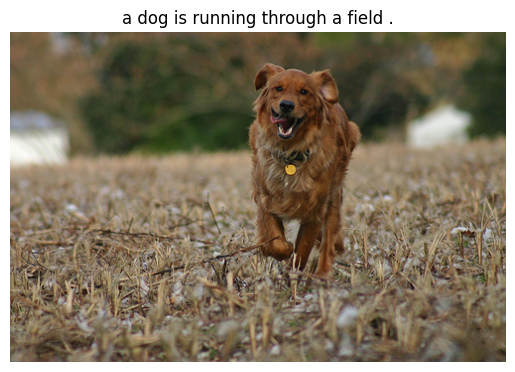

In [ ]:
def show_image_with_caption(image_path, caption):
    """显示图像和生成的描述"""
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, wrap=True)
    plt.show()

# 调用可视化函数
show_image_with_caption(image_path, caption)

In [ ]:
# 示例调用
image_path1 = '/root/autodl-tmp/Flickr8k_Dataset/Flicker8k_Dataset/2322327298_7948338390.jpg'  # 替换为你的图像路径
caption1 = generate_caption_for_image(
    image_path=image_path,
    model=model,
    transform=transform,
    word2idx=train_dataset.word2idx,
    idx2word=train_dataset.idx2word,
    device=device
)

print(f"生成的描述: {caption1}")

In [ ]:
# 示例调用
image_path1 = '/root/autodl-tmp/Flickr8k_Dataset/Flicker8k_Dataset/2322327298_7948338390.jpg'  # 替换为你的图像路径
caption1 = generate_caption_for_image(
    image_path=image_path,
    model=model,
    transform=transform,
    word2idx=train_dataset.word2idx,
    idx2word=train_dataset.idx2word,
    device=device
)

print(f"生成的描述: {caption1}")

A golden dog is running through the snow .


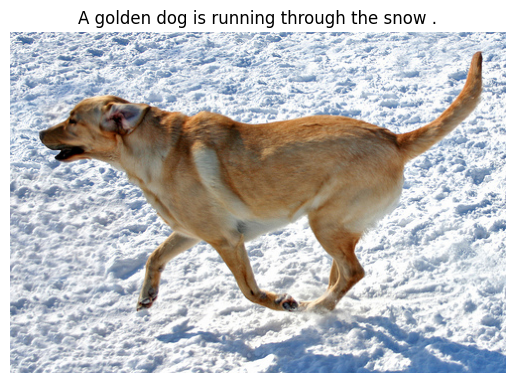

In [ ]:
# 调用可视化函数
show_image_with_caption(image_path1, caption1)

In [ ]:
# 示例调用
image_path2 = '/root/autodl-tmp/Flickr8k_Dataset/Flicker8k_Dataset/3765374230_cb1bbee0cb.jpg'  # 替换为你的图像路径
caption2 = generate_caption_for_image(
    image_path=image_path2,
    model=model,
    transform=transform,
    word2idx=train_dataset.word2idx,
    idx2word=train_dataset.idx2word,
    device=device
)

print(f"生成的描述: {caption2}")

A little girl reacts to a spray of water .


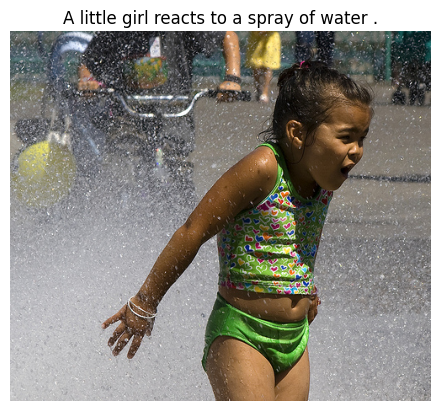

In [ ]:
# 调用可视化函数
show_image_with_caption(image_path2, caption2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/AI-tts/tts-key.json"

In [ ]:
!pip install --upgrade google-cloud-texttospeech

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.cloud import texttospeech
from IPython.display import Audio, display
import tempfile

def speak_wavenet(
    text: str,
    lang_code: str = "en-AU",
    voice_name: str = "en-AU-Wavenet-D",
    speaking_rate: float = 1.0
) -> None:

    client = texttospeech.TextToSpeechClient()

    # 构造合成输入
    synthesis_input = texttospeech.SynthesisInput(text=text)
    voice = texttospeech.VoiceSelectionParams(
        language_code=lang_code,
        name=voice_name,
        ssml_gender=texttospeech.SsmlVoiceGender.MALE
    )
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.MP3,
        speaking_rate=speaking_rate
    )

    # 发起合成请求
    response = client.synthesize_speech(
        input=synthesis_input,
        voice=voice,
        audio_config=audio_config
    )

    # 写入临时文件并播放
    with tempfile.NamedTemporaryFile(suffix=".mp3", delete=False) as out:
        out.write(response.audio_content)
        tmp_path = out.name
    display(Audio(tmp_path, autoplay=True))

In [6]:
# === select which caption to read ===
captions = {
    1: caption,
    2: caption1,
    3: caption2
}

print("Please select a caption to read:")
print("1. caption")
print("2. caption1")
print("3. caption2")

choice_cap = int(input("\nEnter a number (1-3): "))
text_to_read = captions.get(choice_cap)
if not text_to_read:
    raise ValueError("Invalid selection. Please enter a number between 1 and 3.")

print(f"\nSelected caption [{choice_cap}]: {text_to_read}\n")

# === select voice preset ===
presets = {
    1: {"label": "Middle-aged Male",    "lang_code": "en-AU", "voice_name": "en-AU-Chirp3-HD-Sadachbia"},
    2: {"label": "Young Male",          "lang_code": "en-AU", "voice_name": "en-AU-Chirp3-HD-Puck"},
    3: {"label": "Middle-aged Female",  "lang_code": "en-AU", "voice_name": "en-AU-Chirp3-HD-Despina"},
    4: {"label": "Young Female",        "lang_code": "en-AU", "voice_name": "en-AU-News-F"},
}

print("Please select a voice preset:")
for idx, cfg in presets.items():
    print(f"{idx}. {cfg['label']}")

choice_voice = int(input("\nEnter a number (1-4): "))
voice_cfg = presets.get(choice_voice)
if not voice_cfg:
    raise ValueError("Invalid selection. Please enter a number between 1 and 4.")

print(f"\nYou selected voice [{choice_voice}]: {voice_cfg['label']}\n")

# === Playback ===
speak_wavenet(
    text=text_to_read,
    lang_code=voice_cfg["lang_code"],
    voice_name=voice_cfg["voice_name"],
    speaking_rate=1.0
)

NameError: name 'caption' is not defined